In [1]:
import sys
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from natsort import natsorted
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential, Model
from keras.layers import Layer,Input, Dense, Dropout, Activation, Concatenate, Flatten, MaxPooling2D, Convolution2D, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, LSTM, GRU, Bidirectional, Lambda
from keras.regularizers import l2,l1
from keras.optimizers import SGD,Adam,RMSprop
from tensorflow.compat.v1 import InteractiveSession
import keras.backend as K
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras.models import load_model
import keras.metrics
import tensorflow_addons as tfa
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical, plot_model

Using TensorFlow backend.


In [2]:
#plots
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
#confusion matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics as sklearn_metrics
from sklearn.metrics import r2_score

In [3]:
le = LabelEncoder()

In [4]:
print(tf.__version__) #should be TF 2.1

2.1.0


In [5]:
samples = 153924

In [6]:
#load directly from npy files #this step skips the data loading from folders as images
off_dataset = np.load('off_dataset.npy')
target_dataset = np.load('target_dataset.npy')

In [7]:
off_dataset.shape, target_dataset.shape

((153924, 4, 28, 1), (153924, 4, 28, 1))

In [8]:
#get both types of output
output = pd.read_csv('output2.csv')
y = output['y']
freq = output['freq']

In [9]:
Y = le.fit_transform(y).reshape(-1,1)

In [10]:
Y, Y.shape

(array([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]]),
 (153924, 1))

In [11]:
freq = freq.values.reshape(-1,1)
freq, freq.shape

(array([[39.],
        [39.],
        [38.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]]),
 (153924, 1))

In [12]:
#data summary
off_dataset.shape, target_dataset.shape, Y.shape, freq.shape
#should be ((153924, 4, 28, 1), (153924, 4, 28, 1), (153924, 1), (153924, 1))

((153924, 4, 28, 1), (153924, 4, 28, 1), (153924, 1), (153924, 1))

In [13]:
#now model
def clear_sess():
  try:
    del model, history
  except:
    pass
  from keras import backend as K
  K.clear_session()
  return None

In [14]:
clear_sess()

In [15]:
#metrics for classification
metrics_c = [
    #keras.metrics.FalseNegatives(name="fn"),
    #keras.metrics.FalsePositives(name="fp"),
    #keras.metrics.TrueNegatives(name="tn"),
    #keras.metrics.TruePositives(name="tp"),
    #keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc_pr",curve="PR")
]

#metric_r = tfa.metrics.r_square.RSquare()
metric_r = tfa.metrics.r_square.RSquare(dtype=tf.float32, y_shape=(1,))

In [17]:
# #model compile is one of the most important step
# model.compile(optimizer=keras.optimizers.Adam(lr=0.0001),
#               loss={'r': 'mse','c': 'binary_crossentropy'},
#               loss_weights={'r': 0.001,'c': 1.0},
#               metrics={'r':[metric_r],'c':metrics_c})

In [16]:
# # data split for 1D- not used, squeeze is used for removing the channel dimension
# use of indexes to refer data later
img_indexes = list(range(0,samples))


#for conv2D
off_dataset_train, off_dataset_test, target_dataset_train, target_dataset_test, Y_train, Y_test, freq_train, freq_test, train_index, test_index = train_test_split(off_dataset, target_dataset,Y,freq,img_indexes, test_size=0.1, random_state=10) # seed=1, fixed for test set; hold out
off_dataset_train, off_dataset_valid, target_dataset_train, target_dataset_valid, Y_train, Y_valid, freq_train, freq_valid, train_index, valid_index = train_test_split(off_dataset_train, target_dataset_train,Y_train,freq_train,train_index, test_size=1/9, random_state=2) #mostly 1 but can be 2


In [17]:
#train summary
off_dataset_train.shape,target_dataset_train.shape,freq_train.shape,Y_train.shape

((123138, 4, 28, 1), (123138, 4, 28, 1), (123138, 1), (123138, 1))

In [18]:
#validation summary
off_dataset_valid.shape,target_dataset_valid.shape,freq_valid.shape,Y_valid.shape

((15393, 4, 28, 1), (15393, 4, 28, 1), (15393, 1), (15393, 1))

In [19]:
#test summary
off_dataset_test.shape, target_dataset_test.shape, freq_test.shape,Y_test.shape

((15393, 4, 28, 1), (15393, 4, 28, 1), (15393, 1), (15393, 1))

In [20]:
############################### load different models

model_name = 'best_model_seed10_epoch50.hdf5'

#model = keras.models.load_model('models/'+model_name,compile=False)
model = keras.models.load_model(model_name,compile=False)

In [21]:
##### predictions on train-valid-test set

yreg_pred_train, ycls_pred_train = model.predict([off_dataset_train,target_dataset_train])
y_label_pred_train = np.where(ycls_pred_train > 0.5, 1, 0)


# predict on valid set
yreg_pred_valid, ycls_pred_valid = model.predict([off_dataset_valid,target_dataset_valid])
y_label_pred_valid = np.where(ycls_pred_valid > 0.5, 1, 0)


# predict on test set
yreg_pred_test, ycls_pred_test = model.predict([off_dataset_test,target_dataset_test])
y_label_pred_test = np.where(ycls_pred_test > 0.5, 1, 0)

In [114]:
# ###### ROC Curve for train set
# fpr = dict()
# tpr = dict()
# roc_auc = dict()

# for i in range(1):
#     fpr[i], tpr[i], _ = roc_curve(Y_train[:, i], ycls_pred_train[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])
    
# fig, ax = plt.subplots(figsize=(8,7))
# ax.plot(fpr[0], tpr[0],label=' (AUC: %0.3f)' % roc_auc[0], alpha=1)
# ax.plot([0, 1], [0, 1], 'k--')
# ax.set_ylim([0.0, 1.01])
# ax.set_xlim([0.0, 1.01])
# ax.set_yticks(np.arange(0, 1.1, 0.1))
# ax.set_xticks(np.arange(0, 1.1, 0.1))
# ax.set_xlabel('False Positive Rate', fontsize=14)
# ax.set_ylabel('True Positive Rate', fontsize=14)
# ax.tick_params(axis="x", labelsize=12)
# ax.tick_params(axis="y", labelsize=12)
# ax.set_title('ROC Train Set', fontsize=14)
# ax.grid()

# ax.legend(fontsize=12)
# plt.savefig('results/'+model_name+'_train_roc.png', dpi=500, bbox_inches='tight')

In [115]:
# ###### ROC Curve for validation set
# fpr = dict()
# tpr = dict()
# roc_auc = dict()

# for i in range(1):
#     fpr[i], tpr[i], _ = roc_curve(Y_valid[:, i], ycls_pred_valid[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])
    
# fig, ax = plt.subplots(figsize=(8,7))
# ax.plot(fpr[0], tpr[0],label=' (AUC: %0.3f)' % roc_auc[0], alpha=1)
# ax.plot([0, 1], [0, 1], 'k--')
# ax.set_ylim([0.0, 1.01])
# ax.set_xlim([0.0, 1.01])
# ax.set_yticks(np.arange(0, 1.1, 0.1))
# ax.set_xticks(np.arange(0, 1.1, 0.1))
# ax.set_xlabel('False Positive Rate', fontsize=14)
# ax.set_ylabel('True Positive Rate', fontsize=14)
# ax.tick_params(axis="x", labelsize=12)
# ax.tick_params(axis="y", labelsize=12)
# ax.set_title('ROC Validation Set', fontsize=14)
# ax.grid()

# ax.legend(fontsize=12)
# plt.savefig('results/'+model_name+'_valid_roc.png', dpi=500, bbox_inches='tight')

In [116]:
# ###### ROC Curve for test set
# fpr = dict()
# tpr = dict()
# roc_auc = dict()

# for i in range(1):
#     fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], ycls_pred_test[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])
    
# fig, ax = plt.subplots(figsize=(8,7))
# ax.plot(fpr[0], tpr[0],label=' (AUC: %0.3f)' % roc_auc[0], alpha=1)
# ax.plot([0, 1], [0, 1], 'k--')
# ax.set_ylim([0.0, 1.01])
# ax.set_xlim([0.0, 1.01])
# ax.set_yticks(np.arange(0, 1.1, 0.1))
# ax.set_xticks(np.arange(0, 1.1, 0.1))
# ax.set_xlabel('False Positive Rate', fontsize=14)
# ax.set_ylabel('True Positive Rate', fontsize=14)
# ax.tick_params(axis="x", labelsize=12)
# ax.tick_params(axis="y", labelsize=12) 
# ax.set_title('ROC Test Set', fontsize=14)
# ax.grid()

# ax.legend(fontsize=12)
# plt.savefig('results/'+model_name+'_test_roc.png', dpi=500, bbox_inches='tight')

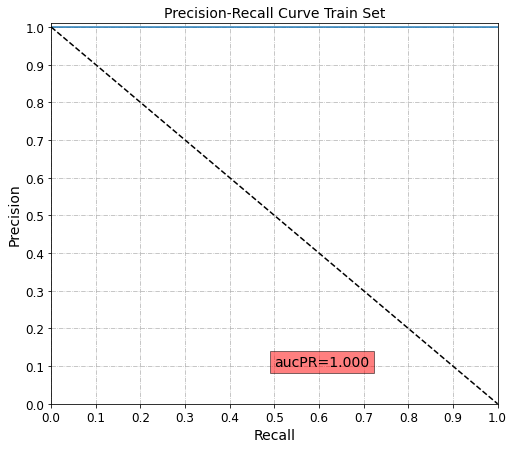

In [39]:
######## important auc PR curve Train Set
precision = dict()
recall = dict()
average_precision = dict()
for i in range(1):
    precision[i], recall[i], _ = precision_recall_curve(Y_train[:, i], ycls_pred_train[:, i])
    average_precision[i] = average_precision_score(Y_train[:, i], ycls_pred_train[:, i])
    
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_train.ravel(), ycls_pred_train.ravel())
average_precision["micro"] = average_precision_score(Y_train, ycls_pred_train, average="micro")
#print('Average precision score , micro-averaged over all classes: {0:0.2f}'
#    .format(average_precision["micro"]))

fig, ax = plt.subplots(figsize=(8,7))
ax.step(recall['micro'], precision['micro'], where='post')

ax.set_xlabel('Recall', fontsize=14)
ax.set_ylabel('Precision', fontsize=14)
ax.plot([0, 1], [1, 0], 'k--')
ax.set_ylim([0.0, 1.01])
ax.set_xlim([0.0, 1.00])
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_title('Precision-Recall Curve Train Set', fontsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12) 
ax.grid(linestyle='-.', linewidth=0.7)
ax.text(0.5, 0.1, 'aucPR={0:0.3f}'.format(average_precision["micro"]), bbox=dict(facecolor='red', alpha=0.5),fontsize=14)
plt.savefig('results/'+model_name+'_train_aurPR.png', dpi=500, bbox_inches='tight')

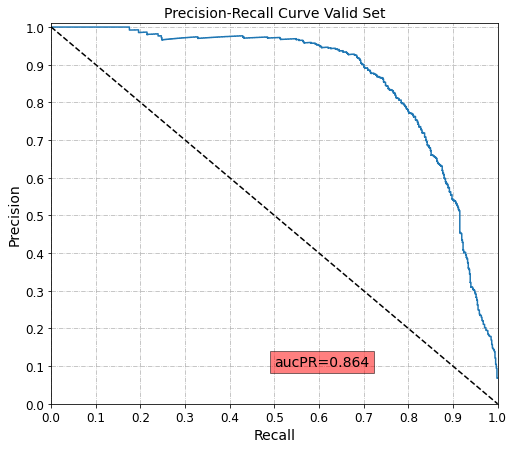

In [40]:
######## important auc PR curve Valid Set
precision = dict()
recall = dict()

average_precision = dict()
for i in range(1):
    precision[i], recall[i], _ = precision_recall_curve(Y_valid[:, i], ycls_pred_valid[:, i])
    average_precision[i] = average_precision_score(Y_valid[:, i], ycls_pred_valid[:, i])
    
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_valid.ravel(), ycls_pred_valid.ravel())
average_precision["micro"] = average_precision_score(Y_valid, ycls_pred_valid, average="micro")
#print('Average precision score , micro-averaged over all classes: {0:0.2f}'
#    .format(average_precision["micro"]))

fig, ax = plt.subplots(figsize=(8,7))
ax.step(recall['micro'], precision['micro'], where='post')

ax.set_xlabel('Recall', fontsize=14)
ax.set_ylabel('Precision', fontsize=14)
ax.plot([0, 1], [1, 0], 'k--')
ax.set_ylim([0.0, 1.01])
ax.set_xlim([0.0, 1.00])
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_title('Precision-Recall Curve Valid Set', fontsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12) 
ax.grid(linestyle='-.', linewidth=0.7)
ax.text(0.5, 0.1, 'aucPR={0:0.3f}'.format(average_precision["micro"]), bbox=dict(facecolor='red', alpha=0.5),fontsize=14)
plt.savefig('results/'+model_name+'_valid_aurPR.png', dpi=500, bbox_inches='tight')

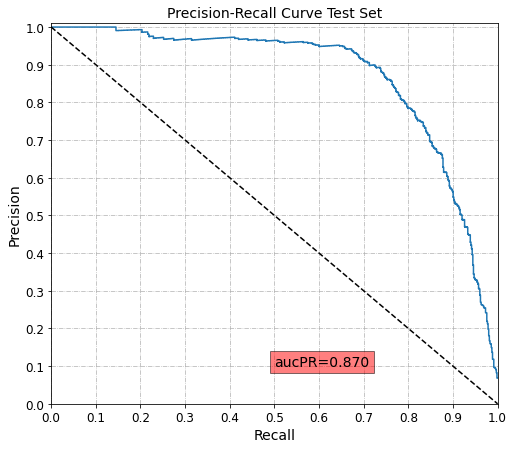

In [41]:
######## important auc PR curve Test Set
precision = dict()
recall = dict()
average_precision = dict()
for i in range(1):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], ycls_pred_test[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], ycls_pred_test[:, i])
    
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(), ycls_pred_test.ravel())
average_precision["micro"] = average_precision_score(Y_test, ycls_pred_test, average="micro")
#print('Average precision score , micro-averaged over all classes: {0:0.2f}'
#    .format(average_precision["micro"]))

fig, ax = plt.subplots(figsize=(8,7))
ax.step(recall['micro'], precision['micro'], where='post')

ax.set_xlabel('Recall', fontsize=14)
ax.set_ylabel('Precision', fontsize=14)
ax.plot([0, 1], [1, 0], 'k--')
ax.set_ylim([0.0, 1.01])
ax.set_xlim([0.0, 1.00])
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_title('Precision-Recall Curve Test Set', fontsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12) 
ax.grid(linestyle='-.', linewidth=0.7)
ax.text(0.5, 0.1, 'aucPR={0:0.3f}'.format(average_precision["micro"]), bbox=dict(facecolor='red', alpha=0.5),fontsize=14)
plt.savefig('results/'+model_name+'_test_aurPR.png', dpi=500, bbox_inches='tight')

In [34]:
### #### confusion metrics for the sets
# #print(sklearn_metrics.confusion_matrix(Y_train, y_label_pred_train))
# tn_train, fp_train, fn_train, tp_train = sklearn_metrics.confusion_matrix(Y_train, y_label_pred_train).ravel()
# tn_valid, fp_valid, fn_valid, tp_valid = sklearn_metrics.confusion_matrix(Y_valid, y_label_pred_valid).ravel()
# tn_test, fp_test, fn_test, tp_test = sklearn_metrics.confusion_matrix(Y_test, y_label_pred_test).ravel()
# print('Training Set   - ', 'True Negatives',tn_train, ',False Positives',fp_train, ',False Negatives',fn_train, ',True Positives',tp_train)
# print('Validation Set - ', 'True Negatives',tn_valid, ' ,False Positives',fp_valid, ' ,False Negatives',fn_valid, ' ,True Positives',tp_valid)
# print('Testing Set    - ', 'True Negatives',tn_test, ' ,False Positives',fp_test, ',False Negatives',fn_test, ',True Positives',tp_test)

In [42]:
######## classification report train set
print('                  Classification Report Training Set')
print(sklearn_metrics.classification_report(Y_train, y_label_pred_train, digits=3))


print('---------------------------------------------------------------------------------------------')
######## classification report train set
print('                  Classification Report Validation Set')
print(sklearn_metrics.classification_report(Y_valid, y_label_pred_valid, digits=3))


print('---------------------------------------------------------------------------------------------')
######## classification report train set
print('                  Classification Report Testing Set')
print(sklearn_metrics.classification_report(Y_test, y_label_pred_test, digits=3))

                  Classification Report Training Set
              precision    recall  f1-score   support

           0      1.000     1.000     1.000    117336
           1      1.000     1.000     1.000      5802

    accuracy                          1.000    123138
   macro avg      1.000     1.000     1.000    123138
weighted avg      1.000     1.000     1.000    123138

---------------------------------------------------------------------------------------------
                  Classification Report Validation Set
              precision    recall  f1-score   support

           0      0.990     0.991     0.991     14708
           1      0.806     0.781     0.793       685

    accuracy                          0.982     15393
   macro avg      0.898     0.886     0.892     15393
weighted avg      0.982     0.982     0.982     15393

---------------------------------------------------------------------------------------------
                  Classification Report Testing Se

In [43]:
# Regression
print('training_r2', r2_score(freq_train, yreg_pred_train))
print('valid_r2', r2_score(freq_valid, yreg_pred_valid))
print('test_r2', r2_score(freq_test, yreg_pred_test))

training_r2 0.9190660227020315
valid_r2 0.6108414652928285
test_r2 0.5601188649477067


In [1]:
#### best model, do not regularise classification, put 0.0005 in regression